In [137]:
import os
import sys

base_dir = os.getcwd()
sys.path.append(base_dir)
sys.path.append(os.path.join(base_dir, 'texture_synthesis_pytorch'))

import torch
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

import src.prototype as p

# Reload library in Jupyter to load changes
import importlib
importlib.reload(p)

TARGET_IMAGE_NAME = 'unity_cube.jpg'
TARGET_OUTPUT_LAYER = 27 # Possible MaxPool values: 4, 9, 18, 27
NUM_OUTPUT_REPETITION = 4
HORIZON_LENGTH = 64
MEAN_ACTIVATION = 0.01


model = p.load_model(TARGET_IMAGE_NAME, base_dir)
out_batch = p.partial_net_at(model, TARGET_OUTPUT_LAYER)

print(TARGET_OUTPUT_LAYER, out_batch.shape, np.prod(out_batch.shape))

"""
out = out_batch[0, :, :, :]
gr = gram_matrix(out_batch)

distance_map = p.generate_distance_map(out, pixel_radius=4)

num_output_repetition = 4
out_large = np.broadcast_to(out, (NUM_OUTPUT_REPETITION,) + out.shape)
print(out_large.shape)

new = p.distanced_gram_matrix(out, distance_map)
new_gram = p.gram_matrix(new)
np.fill_diagonal(new_gram, 0)
"""

27 (1, 512, 16, 16) 131072


'\nout = out_batch[0, :, :, :]\ngr = gram_matrix(out_batch)\n\ndistance_map = p.generate_distance_map(out, pixel_radius=4)\n\nnum_output_repetition = 4\nout_large = np.broadcast_to(out, (NUM_OUTPUT_REPETITION,) + out.shape)\nprint(out_large.shape)\n\nnew = p.distanced_gram_matrix(out, distance_map)\nnew_gram = p.gram_matrix(new)\nnp.fill_diagonal(new_gram, 0)\n'

In [235]:
C_raw = out_batch[0, ...]
C = np.broadcast_to(C_raw, (NUM_OUTPUT_REPETITION,) + C_raw.shape).astype(C_raw.dtype)
O = np.empty(shape=C.shape, dtype=C.dtype)

G = p.gram_matrix(C_raw).astype(C.dtype)
G_d = p.distanced_gram_matrix(C_raw, p.generate_distance_map(C_raw, pixel_radius=4)).astype(C.dtype)

S = np.random.rand(*C.shape).astype(C.dtype)
L = np.random.rand(*C.shape).astype(C.dtype)

#H = np.empty(shape=(HORIZON_LENGTH,) + O.shape, dtype=C.dtype)
H = MEAN_ACTIVATION * np.ones(shape=O.shape, dtype=C.dtype)

elements = [C_raw, C, O, G, G_d, S, L, H]
element_names = ['C_raw', 'C', 'O', 'G', 'G_d', 'S', 'L', 'H']

total_nbytes = 0
for el, en in zip(elements, element_names):
    print(f"{en}:\t{el.shape}")
    nbytes = el.nbytes / 1024 / 1024
    total_nbytes += nbytes
    print(f"\t{nbytes} MB")
    
print('===========================')
print(f"Total MB:\t{round(total_nbytes,4)}")

C_raw:	(512, 16, 16)
	0.5 MB
C:	(4, 512, 16, 16)
	2.0 MB
O:	(4, 512, 16, 16)
	2.0 MB
G:	(16, 16)
	0.0009765625 MB
G_d:	(512, 16, 16)
	0.5 MB
S:	(4, 512, 16, 16)
	2.0 MB
L:	(4, 512, 16, 16)
	2.0 MB
H:	(4, 512, 16, 16)
	2.0 MB
Total MB:	11.001


(1, 1000000)

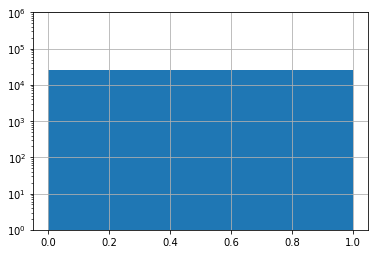

In [144]:
plt.hist(S.reshape(np.prod(S.shape)), bins=20)
plt.yscale('log')
plt.grid(True)
plt.ylim([1, 1000000])

In [236]:
S_UPDATE_SPEED = 0.1

h_mean = list()
h_last = list()
s_last = list()

for i in range(2000):
    # Generate NEW Output O
    L = G_d * S
    O = C * L

    # Save current output in H and create a weighted mean with previous values
    factor = (1/HORIZON_LENGTH)
    H = factor * np.clip(O, a_min=-1.0, a_max=1.0) + (1-factor) * H
    
    h_mean.append(np.mean(H))
    h_last.append(H[0,0,0,-1])
    s_last.append(S[0,0,0,-1])
    
    # S Update
    S -= S_UPDATE_SPEED * (H - MEAN_ACTIVATION)
    S = np.clip(S, a_min=-1.0, a_max=1.0)

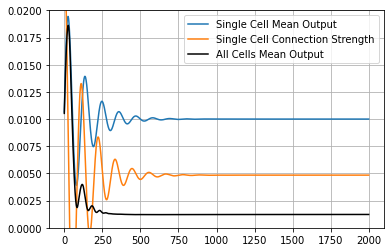

In [240]:
plt.plot(h_last, label='Single Cell Mean Output')
plt.plot(s_last, label='Single Cell Connection Strength')
plt.plot(h_mean, label='All Cells Mean Output', color='black')
plt.ylim([0, 0.02])
plt.grid(True)
plt.legend()

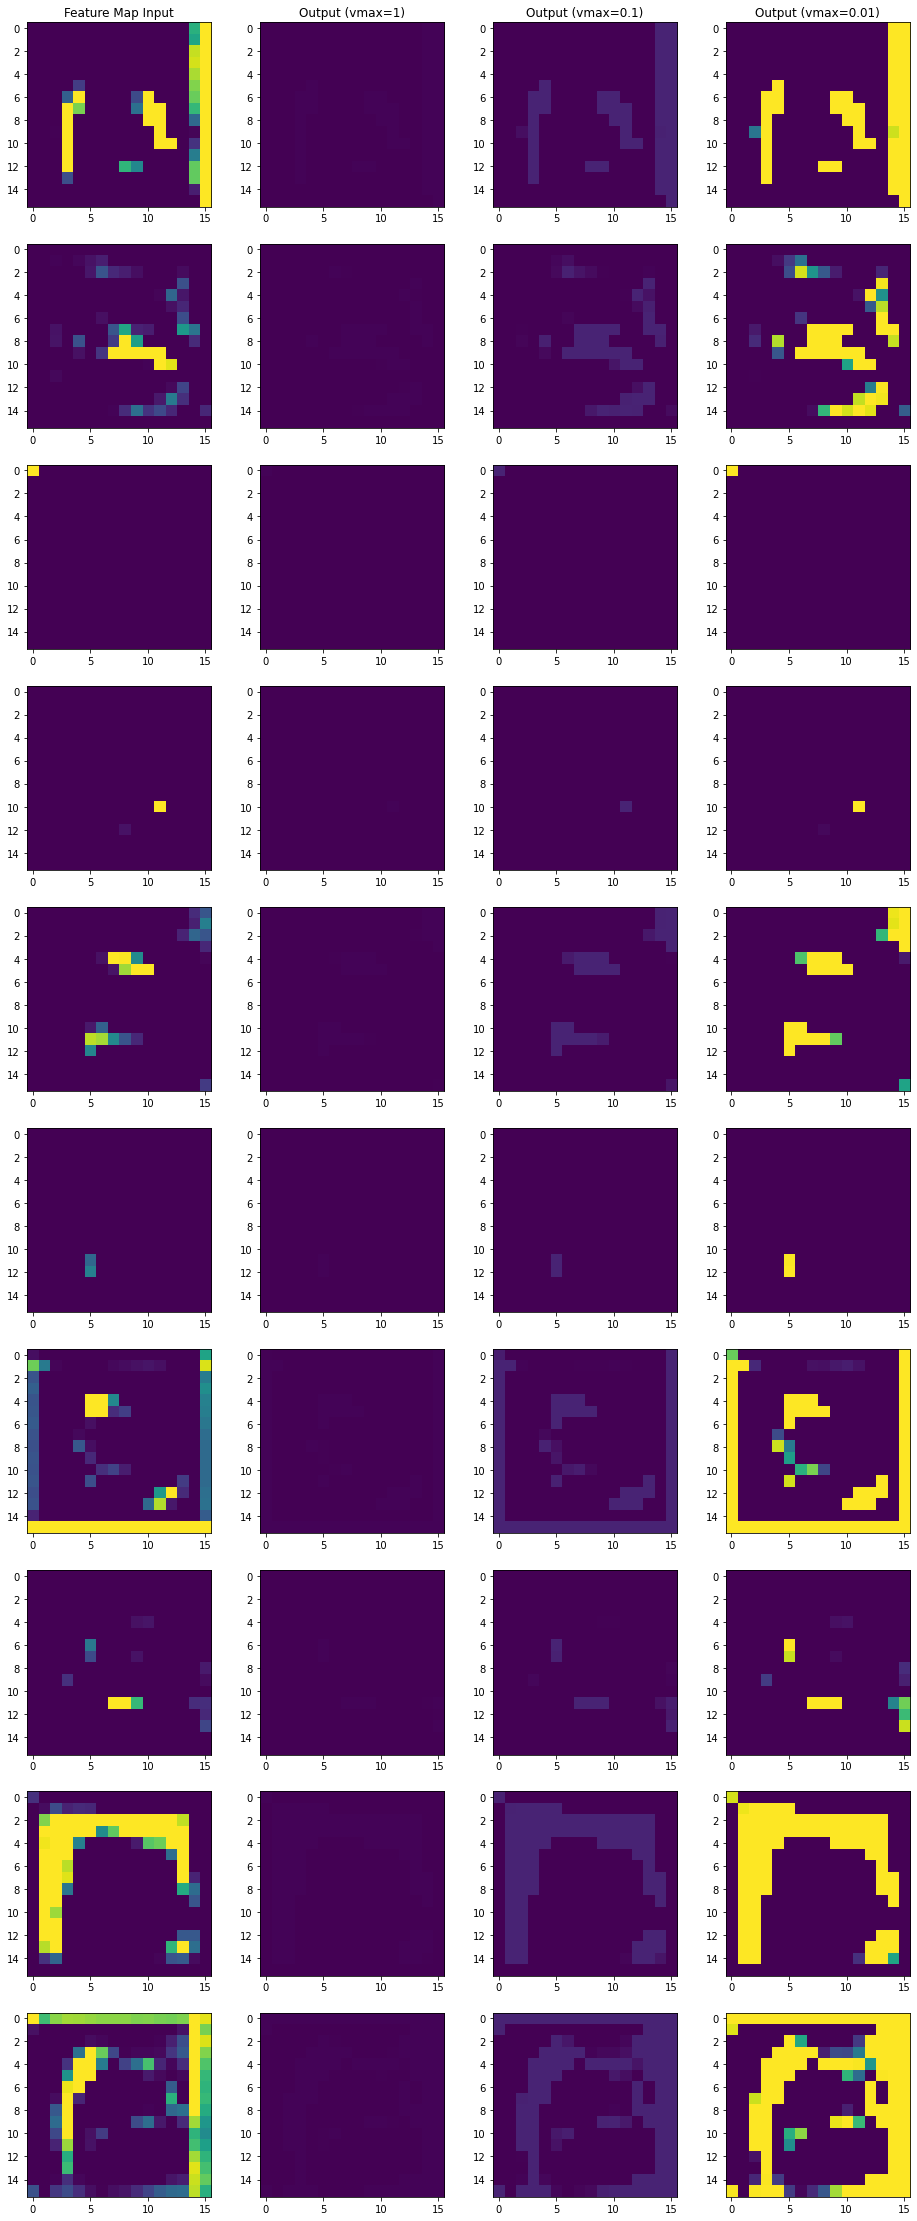

In [238]:
num_plots = 10
fig, axs = plt.subplots(num_plots, 4, figsize=(16, num_plots*4))

for i in range(num_plots):
    axs[i, 0].imshow(C[0,i,:,:], vmin=0, vmax=1)
    axs[i, 1].imshow(O[0,i,:,:], vmin=0, vmax=1)
    axs[i, 2].imshow(O[0,i,:,:], vmin=0, vmax=0.1)
    axs[i, 3].imshow(O[0,i,:,:], vmin=0, vmax=0.01)
    
    if i == 0:
        axs[i, 0].set_title('Feature Map Input')
        axs[i, 1].set_title('Output (vmax=1)')
        axs[i, 2].set_title('Output (vmax=0.1)')
        axs[i, 3].set_title('Output (vmax=0.01)')

NameError: name 'out' is not defined

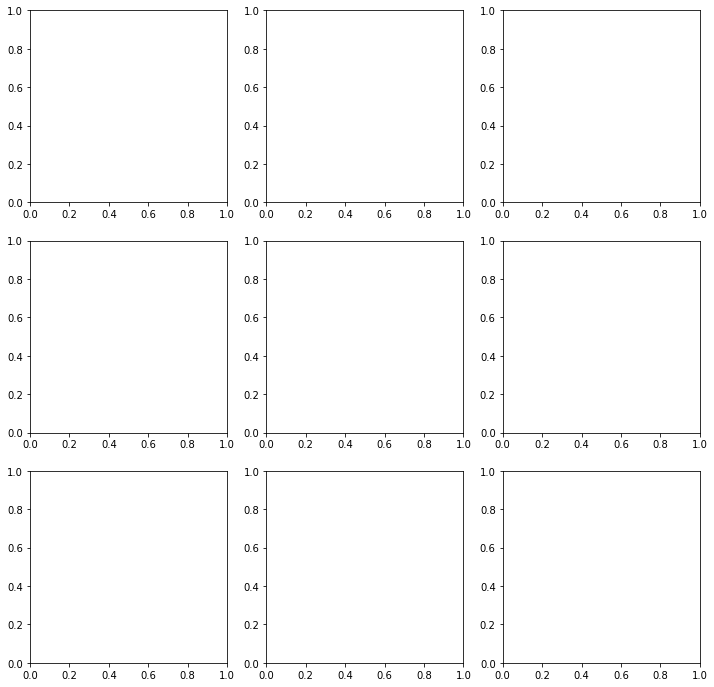

In [155]:
#INDEX_A = np.random.randint(0, out.shape[0])
#INDEX_B = np.random.randint(0, out.shape[0])
INDEX_A = 35
INDEX_B = 12

fig, axs = plt.subplots(3, 3, figsize=(12,12))

# Feature Map INPUT
axs[0,0].imshow(out[INDEX_A, :, :], cmap='viridis')
axs[0,0].set_title('Feature Map #' + str(INDEX_A))
axs[0,1].imshow(out[INDEX_B, :, :], cmap='viridis')
axs[0,1].set_title('Feature Map #' + str(INDEX_B))
axs[0,2].imshow(tex_syn_utilities.load_image(os.path.join(base_dir, 'images', TARGET_IMAGE_NAME)))
axs[0,2].set_title('Original Image')

# Feature Map "Distance-Scaled"
axs[1,0].imshow(new[INDEX_A, :, :], cmap='viridis')
axs[1,0].set_title('Blurred FM #' + str(INDEX_A))
axs[1,1].imshow(new[INDEX_B, :, :], cmap='viridis')
axs[1,1].set_title('Blurred FM #' + str(INDEX_B))
# Feature Maps multiplied with distance scaling
axs[1,2].imshow(new[INDEX_A, :, :] * new[INDEX_B, :, :], cmap='viridis')
axs[1,2].set_title('Blurred Product of FMs #' + str(INDEX_A) + ' & #' + str(INDEX_B))

# Original Gram Matrix
axs[2,0].imshow(gr, cmap='viridis')
axs[2,0].set_title('Gram-Matrix')
axs[2,1].imshow(build_manhattan_template(out), cmap='viridis')
axs[2,1].set_title('"Neighborhood Blurring" Template')
# Gram Matrix of distance scaled product
axs[2,2].imshow(new_gram, cmap='viridis')
axs[2,2].set_title('Gram: Blurred FM-Products')